# Progetto big data

requisiti:
* pandas
* spark 
* langchain
* openai
* pip3 install openai==0.28
* matplotlib
* json


## 1. Inizializzazione
* pre-requisiti: file csv suddiviso tassonomicamente (e.g: "skill-Linux") e un blocco ID (e.g:"ID-name")
* venv con librerie

### 1.1 librerie e API

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import *

import pandas as pd
import numpy as np

from collections import Counter
from langchain_community.document_loaders import PySparkDataFrameLoader
from langchain.prompts import PromptTemplate
from langchain.llms import OpenAI
from langchain.chains import LLMChain

import os
import json

import openai
from functools import reduce
import builtins

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors



inserire la propria api key

In [ ]:
openai.api_key = ""

### 1.2 creazione spark 

In [4]:
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Il mio primo progetto Spark") \
    .getOrCreate()


25/02/27 21:06:17 WARN Utils: Your hostname, MacBook-Pro-di-Daniele-2.local resolves to a loopback address: 127.0.0.1; using 192.168.131.161 instead (on interface en0)
25/02/27 21:06:17 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/27 21:06:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## 2. apertura csv e lettura 
cambiare il csv se necessario

In [5]:
df = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load("skill_matrix.csv")

#Get column names
columns = df.columns

In [6]:
#numero colonne
num_columns = len(df.columns)
num_rows = df.count()

print(f"Number of columns (features): {num_columns}")
print(f"Number of rows (users): {num_rows}")


Number of columns (features): 129
Number of rows (users): 44


## 3 blocchi tematici

In [7]:
#Estrarre il blocco da ogni colonna
thematic_blocks = [col.split('-', 1)[0] for col in columns]  #prendi la parte prima del primo '-'

#Contare le ricorrenze di ogni blocco
counts = Counter(thematic_blocks)

print("Numero di blocchi tematici distinti:", len(counts))
for block, freq in counts.items():
    print(f"{block} -> {freq} colonne")

#Costruisci un dizionario di blocchi {nome_blocco: [colonna1, colonna2, ...]}
blocks_dict = {}
for col in columns:
    block_name = col.split('-', 1)[0]
    if block_name not in blocks_dict:
        blocks_dict[block_name] = []
    blocks_dict[block_name].append(col)

#print
print("Struttura dei blocchi estratti dinamicamente:")
print(json.dumps(blocks_dict, indent=2))

Numero di blocchi tematici distinti: 8
ID -> 2 colonne
work_activities -> 9 colonne
knowledge -> 15 colonne
tools -> 16 colonne
tech_skills -> 39 colonne
abilities -> 8 colonne
tasks -> 26 colonne
skills -> 14 colonne
Struttura dei blocchi estratti dinamicamente:
{
  "ID": [
    "ID-ID",
    "ID-name"
  ],
  "work_activities": [
    "work_activities-Resolving Conflicts and Negotiating with Others",
    "work_activities-Evaluating Information to Determine Compliance with Standards",
    "work_activities-Processing Information",
    "work_activities-Developing Objectives and Strategies",
    "work_activities-Establishing and Maintaining Interpersonal Relationships",
    "work_activities-Making Decisions and Solving Problems",
    "work_activities-Thinking Creatively",
    "work_activities-Getting Information",
    "work_activities-Training and Teaching Others"
  ],
  "knowledge": [
    "knowledge-Customer and Personal Service",
    "knowledge-Design",
    "knowledge-Production and Proces

## 4 LLM-Query

### 4.1 parsing query con gpt

In [8]:
def parse_user_query_strict(query, blocks_dictionary):
    """
    Usa GPT per analizzare la query dell'utente e identificare 
    quali blocchi e/o feature potrebbero essere rilevanti,
    assegnando anche un peso (0-1) a ciascuna feature/blocco.

    Restituisce un dizionario con la struttura:
    {
      "relevant_blocks": [
        {
          "block_name": "NomeBlocco",
          "weight": 0.8
        }
      ],
      "relevant_features": [
        {
          "name": "NomeColonna",
          "weight": 1.0
        }
      ]
    }
    """
    import json
    import openai

    # Prompt per GPT: chiediamo di essere molto selettivi,
    # aggiungendo una richiesta di weight da 0 a 1.
    prompt = f"""
    Devi analizzare la query di un utente su un dataset di skill,
    DIVISO IN BLOCCHI, ognuno con diverse colonne (feature).
    Ecco la struttura (blocks_dictionary) in JSON:
    {json.dumps(blocks_dictionary, indent=2)}

    L'utente fa la seguente richiesta: "{query}"

    *SII MOLTO SELETTIVO*:
    - Se la colonna o il blocco non è strettamente correlato alla richiesta, NON includerlo.
    - Se ritieni che l'utente voglia TUTTO il blocco, allora aggiungi un oggetto in "relevant_blocks"
      con {{"block_name": "NomeBlocco", "weight": <valore 0-1>}}.
    - Se invece l'utente è interessato a UNA o POCHI argomenti all'interno di un blocco,
      indica le feature (colonne) specifiche in "relevant_features", 
      con {{"name": "NomeColonna", "weight": <valore 0-1>}}.
    - Non aggiungere nulla che non sia chiaramente correlato alla query.
    - Se una skill è più importante, assegnale un peso più alto (vicino a 1).
      Se è rilevante ma secondaria, peso intermedio (0.3-0.7).
    - Restituisci SOLO un JSON **valido** con questa struttura:
    {{
      "relevant_blocks": [
        {{
          "block_name": "NomeBlocco",
          "weight": 0.8
        }}
      ],
      "relevant_features": [
        {{
          "name": "NomeColonna",
          "weight": 1.0
        }}
      ]
    }}
    """

    try:
        response = openai.ChatCompletion.create(
            model="gpt-4",
            messages=[
                {
                    "role": "system",
                    "content": (
                        "Sei un assistente che analizza la query dell'utente "
                        "per trovare i blocchi e/o le feature più rilevanti, "
                        "assegnando pesi (0-1) in modo selettivo."
                    )
                },
                {
                    "role": "user",
                    "content": prompt
                }
            ],
            temperature=0.0
        )
        content = response["choices"][0]["message"]["content"]
        parsed_json = json.loads(content)  
        return parsed_json
    except (json.JSONDecodeError, KeyError):
        return {
            "relevant_blocks": [],
            "relevant_features": []
        }
    except Exception as e:
        print("Errore inaspettato nella chiamata a GPT:", e)
        return {
            "relevant_blocks": [],
            "relevant_features": []
        }


### 4.2 funzione colonne corrispondenti
* prende l'elenco di blocchi tematici e delle feature
* crea un set nuovo
* controlla se GPT indica un blocco o una o più feature e l'aggiunge nel set restituendola
* se viene richiesto tutto un blocco si assegnerà tutto quel blocco, sennò solo delle feature specifiche

In [9]:

def find_relevant_columns(parsed_dict, blocks_dictionary):
    """
    Dati i blocchi/feature con relativi pesi (da 0 a 1),
    costruisce un dizionario {colonna: peso} da selezionare.

    Logica invariata nella selezione (molto severa), con la differenza
    che i relevant_blocks e relevant_features sono liste di oggetti:
      { "block_name": "...", "weight": ... }
      { "name": "...",        "weight": ... }
    
    - Se GPT include un blocco in 'relevant_blocks' ma specifica anche alcune feature
      di quel blocco in 'relevant_features', prendiamo SOLO quelle feature.
    - Se GPT include un blocco (weight=W) e non specifica feature particolari,
      includiamo TUTTO il blocco con peso=W.
    - Se GPT specifica feature di un blocco che non compare in 'relevant_blocks',
      includiamo solo quelle feature con i loro pesi.
    """

    relevant_blocks = parsed_dict.get("relevant_blocks", [])
    relevant_feats = parsed_dict.get("relevant_features", [])

    #Costruiamo un dict: block_name -> weight
    block_weights = {}
    for b in relevant_blocks:
        bname = b.get("block_name")
        w = b.get("weight", 0.5)  # default 0.5 se non presente
        if bname and bname in blocks_dictionary:
            block_weights[bname] = w

    #Costruiamo un dict: feature_name -> weight
    feature_weights = {}
    for f in relevant_feats:
        fname = f.get("name")
        w = f.get("weight", 0.5)
        if fname:
            feature_weights[fname] = w

    #Iniziamo a costruire un dict finale col -> peso
    final_col_weights = {}

    # 1) Se un blocco è elencato, ma GPT ha specificato feature di quel blocco...
    #    -> usiamo solo quelle feature con i loro pesi
    #    altrimenti, includiamo tutto il blocco con lo stesso peso di blocco.
    for block_name, wblock in block_weights.items():
        # Verifichiamo se ci sono feature di questo blocco
        block_specific_feats = []
        for feat_name, wfeat in feature_weights.items():
            # verifichiamo se feat_name appartiene al blocco in blocks_dictionary
            cols_in_block = blocks_dictionary.get(block_name, [])
            if feat_name in cols_in_block:
                block_specific_feats.append((feat_name, wfeat))

        if len(block_specific_feats) > 0:
            # Abbiamo feature specifiche -> aggiungiamo solo quelle
            for (colname, colweight) in block_specific_feats:
                final_col_weights[colname] = colweight
        else:
            # Nessuna feature specifica -> includi tutto il blocco
            for col in blocks_dictionary.get(block_name, []):
                final_col_weights[col] = wblock

    # 2) Gestione di feature non citate in relevant_blocks (o citate fuori blocco)
    #    -> se GPT ha messo per qualche feature (f.name, f.weight) e
    #       il block non è in block_weights, la aggiungiamo lo stesso
    for feat_name, wfeat in feature_weights.items():
        # se non l'abbiamo già inserita
        if feat_name not in final_col_weights:
            final_col_weights[feat_name] = wfeat

    # Stampa a video le feature trovate e il relativo peso
    print("Feature (o colonne) trovate da GPT con peso:")
    for col, w in final_col_weights.items():
        print(f"  - {col} -> {w}")

    return final_col_weights


### 4.3 richiesta query ed esecuzione operazione 
* l'utente inserisce se vuole usare un operatore "AND" (quindi verranno restituiti tutti gli utenti che rispettano tutte le condizioni)
* oppure un "NOR" (qualsiasi utente abbia almeno una di quelle skill)

In [ ]:
user_query = input("Inserisci la query: ")

#Analisi della query con GPT
parsed_result = parse_user_query_strict(user_query, blocks_dict)

#Ottengo un dizionario {colonna: peso} invece di una semplice lista
col_weights_dict = find_relevant_columns(parsed_result, blocks_dict)

#Se non c'è alcuna colonna, GPT non ha trovato corrispondenze
if len(col_weights_dict) == 0:
    print("Nessuna feature trovata da GPT (o GPT non è sicuro).")
    # Mostra solo ID
    id_block_columns = blocks_dict.get("ID", [])
    df.select(id_block_columns).show(truncate=False)
else:
    #Aggiungiamo all'inizio la presenza di tutte le colonne del blocco "ID" 
    id_block_columns = blocks_dict.get("ID", [])
    final_columns_with_weights = {}

    #Inserisci ID con peso speciale (es. 0.0) o semplicemente fissi
    for col_id in id_block_columns:
        if col_id in df.columns:
            final_columns_with_weights[col_id] = None 

    #Aggiungiamo le colonne GPT trovate (col->weight) 
    for c, w in col_weights_dict.items():
        if c in df.columns:
            final_columns_with_weights[c] = w

    #Ordina le colonne:
    #    - prima ID in ordine in cui compaiono
    #    - poi le skill 
    id_cols = list(final_columns_with_weights.keys())[:len(id_block_columns)]  #i primi len(id_block_columns) sono ID
    skill_cols_and_weights = [(c, w) for c, w in final_columns_with_weights.items() if w is not None]
    skill_cols_and_weights.sort(key=lambda x: x[1], reverse=True)

    #costruiamo la lista finale di colonne
    final_columns = id_cols + [x[0] for x in skill_cols_and_weights]

    print("Colonne finali da selezionare (ID + skill ordinate per peso):", final_columns)


    #Filtro con Spark: prendi gli utenti che hanno almeno una skill = 1 tra quelle scelte
    skill_only_columns = [x[0] for x in skill_cols_and_weights]
    if skill_only_columns:
        #Crea condizioni NOR solo se ci sono skill
        filter_conditions = [F.col(c) == 1 for c in skill_only_columns]
        combined_filter = reduce(Column.__or__, filter_conditions)
        df_filtered = df.filter(combined_filter).select(final_columns)
    else:
        #Se non ci sono skill, seleziona solo ID senza filtrare
        df_filtered = df.select(final_columns)

Feature (o colonne) trovate da GPT con peso:
  - skills-Complex Problem Solving -> 1.0
  - skills-Operation and Control -> 1.0
  - skills-Operations Analysis -> 1.0
  - skills-Science -> 1.0
  - skills-Troubleshooting -> 1.0
  - skills-Technology Design -> 1.0
  - skills-Repairing -> 1.0
  - skills-Equipment Maintenance -> 1.0
  - skills-Learning Strategies -> 1.0
  - skills-Programming -> 1.0
  - skills-Negotiation -> 1.0
  - skills-Coordination -> 1.0
  - skills-Monitoring -> 1.0
  - skills-Quality Control Analysis -> 1.0
  - knowledge-Customer and Personal Service -> 1.0
  - knowledge-Design -> 1.0
  - knowledge-Production and Processing -> 1.0
  - knowledge-English Language -> 1.0
  - knowledge-Communications and Media -> 1.0
  - knowledge-Administrative -> 1.0
  - knowledge-Education and Training -> 1.0
  - knowledge-Fine Arts -> 1.0
  - knowledge-Mechanical -> 1.0
  - knowledge-Foreign Language -> 1.0
  - knowledge-Sales and Marketing -> 1.0
  - knowledge-Public Safety and Securi

In [ ]:
#stampa query utente
print(user_query)

indicami tutti gli utenti che abbiano competenze e conoscenze, secondariamente che sappiano usare il tritatutto e sarebbe gradita una conoscenza di excel


## 5. Rank utenti e visualizzazione grafici
* elenca gli utenti, quelli con più skill saranno nei primi posti
* crea una "heatmap" ibrida per interpretare meglio i dati
* restituisce dei grafici a torta

### 5.1 conversione a pandas

In [16]:
def convert_spark_to_pandas(spark_df):
    columns = spark_df.columns
    data = []
    for row in spark_df.collect():
        data.append(row.asDict())
    return pd.DataFrame(data, columns=columns)

### 5.2 tabella con heatmap

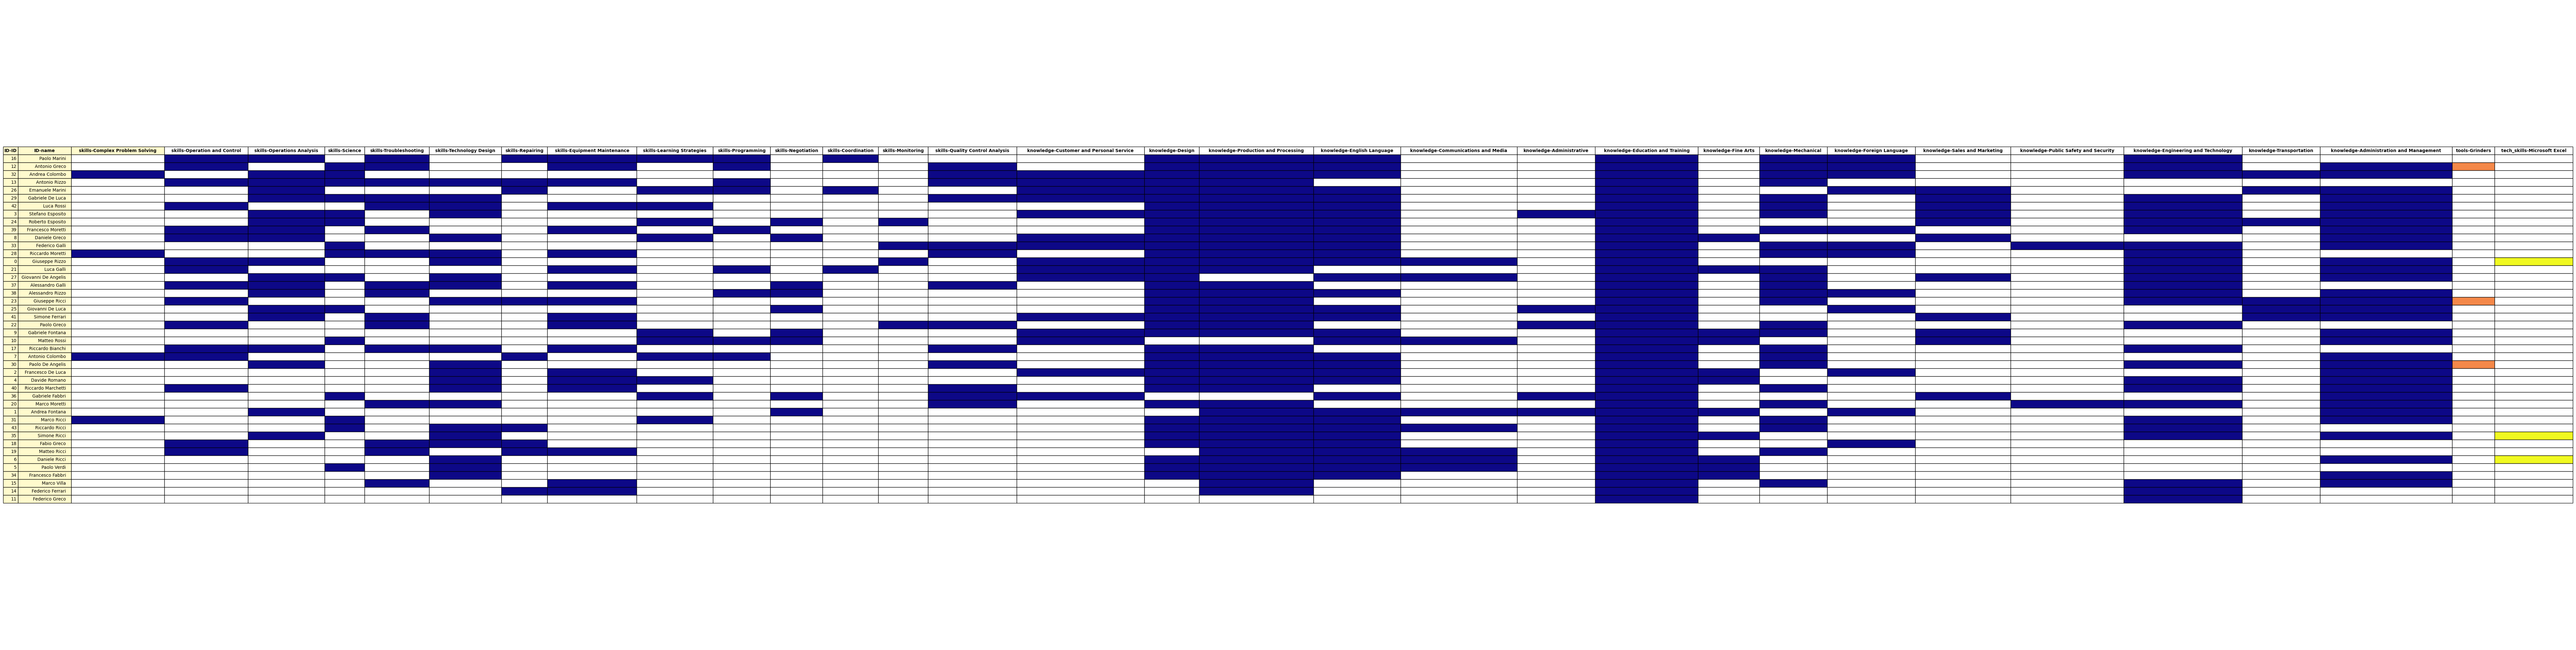

In [ ]:
#Convertiamo il DataFrame Spark in Pandas
pdf = convert_spark_to_pandas(df_filtered)

#Calcolo punteggio pesato
weighted_scores = []
for idx, row in pdf.iterrows():
    score = 0.0
    for col in skill_only_columns:
        skill_value = row[col]  # 0 o 1
        weight = col_weights_dict.get(col, 0)
        score += skill_value * weight
    weighted_scores.append(score)

pdf['weighted_score'] = weighted_scores

#Ordiniamo o filtriamo e salviamo in pdf_sorted
pdf_sorted = pdf.sort_values('weighted_score', ascending=False)


#Rimuove l'ultima colonna da pdf_sorted
pdf_sorted.drop(columns=[pdf_sorted.columns[-1]], inplace=True)

num_users = len(pdf_sorted)
scelta = input(f"Ci sono {num_users} utenti, quanti ne vuoi visualizzare? (inserisci un numero o 'nessuno'): ")

if scelta.lower() == 'nessuno':
    pdf_sorted = pdf_sorted.iloc[0:0]  #DataFrame vuoto
else:
    try:
        n = int(scelta)
        # e l'utente inserisce un numero > del totale utenti, mostriamo tutti
        if n > num_users:
            n = num_users
        pdf_sorted = pdf_sorted.head(n)
    except ValueError:
        # Se l'input non è un numero, mostriamo tutti gli utenti
        print("Input non valido, mostro tutti gli utenti:")

#Se dopo la selezione il DataFrame è vuoto, segnaliamo che non ci sono utenti
if pdf_sorted.empty:
    print("Non ci sono utenti da visualizzare.")

#Creiamo una mappa "peso → frazione" per usare un unico colore per colonne con lo stesso peso
unique_weights = sorted({col_weights_dict.get(c, 0) for c in skill_only_columns})
if len(unique_weights) > 1:
    min_w, max_w = unique_weights[0], unique_weights[-1]
    weight_to_fraction = {
        w: (w - min_w) / (max_w - min_w)
        for w in unique_weights
    }
else:
    # Se esiste un solo peso (o nessuno), assegniamo una frazione fissa
    weight_to_fraction = {w: 0.5 for w in unique_weights}

#Creiamo la figura e l'axes
fig, ax = plt.subplots(figsize=(14, 0.6 * len(pdf_sorted)))
ax.axis('off')

#Generiamo la tabella
table = ax.table(
    cellText=pdf_sorted.values.astype(str),
    colLabels=pdf_sorted.columns,
    loc='center'
)

#Header in grassetto + dimensione font
for col_index, label in enumerate(pdf_sorted.columns):
    cell_header = table.get_celld()[(0, col_index)]
    cell_header.get_text().set_weight('bold')
    cell_header.set_fontsize(10)
    
    # Se vuoi colorare anche l'header delle prime 3 colonne
    if col_index < 3:
        cell_header.set_facecolor('LemonChiffon')  # colore pastello caldo

#Aumentiamo la dimensione delle celle (1.5 volte più grandi per favorirne la visualizzazione)
table.scale(1.5, 1.5)

#Otteniamo numero di righe e di colonne (escludendo l’header nella tabella)
nrows = len(pdf_sorted)
ncols = len(pdf_sorted.columns)

#Colormap desiderata
cmap = plt.get_cmap('plasma')

#Ciclo sulle righe della tabella (i+1 perché la riga 0 è l'header)
for i in range(nrows):
    for j in range(ncols):
        cell = table.get_celld()[(i+1, j)]
        val_str = pdf_sorted.iloc[i, j]

        #Prime 2 colonne: sfondo pastello
        if j < 2:
            cell.set_facecolor('LemonChiffon')
            continue

        #Dalla quarta colonna in poi => color in base al peso della colonna
        try:
            val = float(val_str)
        except ValueError:
            # Se non è convertibile in float, la lasciamo bianca
            cell.set_facecolor('white')
            continue

        if pd.isna(val) or val == 0.0:
            #Se 0 o NaN => cella bianca
            cell.set_facecolor('white')
            cell.get_text().set_text('')
        else:
            #Recuperiamo il peso di questa colonna
            col_name = pdf_sorted.columns[j]
            w = col_weights_dict.get(col_name, 0)
            #Calcoliamo la frazione associata a questo peso
            fraction = weight_to_fraction.get(w, 0.0)
            #Con plasma, fraction=0 => colore più chiaro, fraction=1 => colore più scuro (o viceversa)
            color = cmap(1 - fraction)
            cell.set_facecolor(color)
            cell.get_text().set_text('')

table.auto_set_column_width(col=list(range(ncols)))

plt.show()


### 5.3 grafico sperimentale frequenze

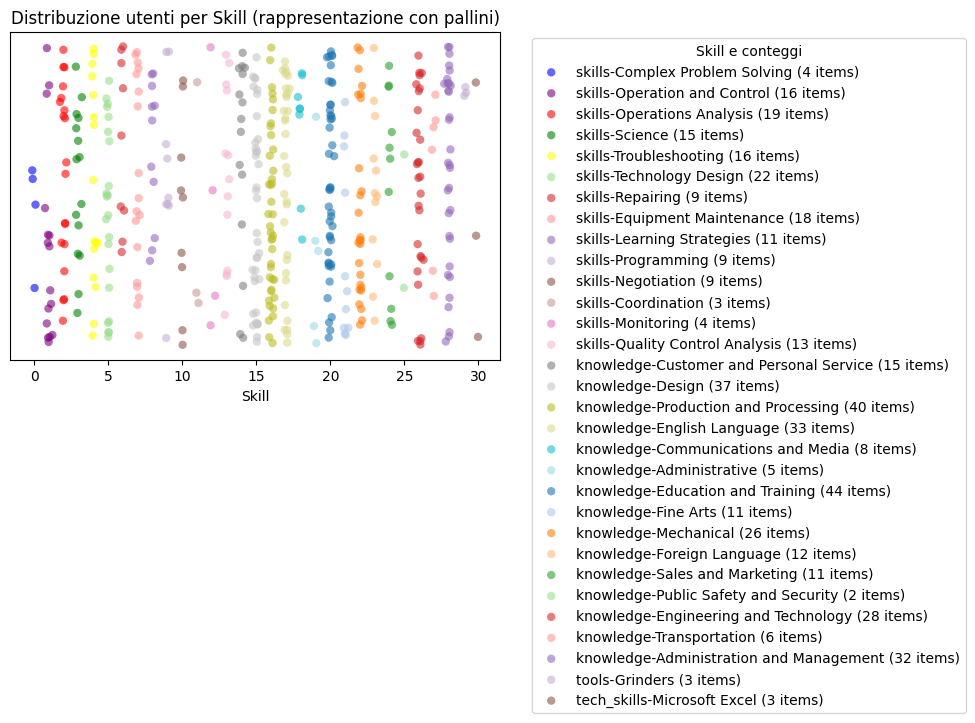

In [ ]:
fig2, ax2 = plt.subplots(figsize=(10, 6))

#Lista di colori prefissati (manteniamo quelli originali)
colors_predefined = ['blue', 'purple', 'red', 'green', 'yellow']

#Ciclo per ogni skill presente in skill_only_columns
for i, skill in enumerate(skill_only_columns):
    #Calcola quanti utenti hanno la skill (valore 1)
    count = int(pdf_sorted[skill].sum())
    #Genera posizioni casuali per i pallini intorno a x=i (per evitare sovrapposizioni)
    x_positions = np.random.normal(i, 0.1, count)
    #Distribuzione dei pallini lungo l'asse y per dare compattezza
    y_positions = np.random.rand(count) * 10  # range y da 0 a 10
    
    #Se il numero di skill supera i colori prefissati, usa un colormap
    if i < len(colors_predefined):
        color = colors_predefined[i]
    else:
        cmap = plt.get_cmap('tab20')
        color = cmap(i % 20)
    
    ax2.scatter(x_positions, y_positions, color=color, alpha=0.6, edgecolor='none',
                label=f'{skill} ({count} items)')

ax2.set_title('Distribuzione utenti per Skill (rappresentazione con pallini)')
ax2.set_xlabel('Skill')
ax2.set_yticks([])
ax2.set_ylabel('')
ax2.legend(title='Skill e conteggi', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


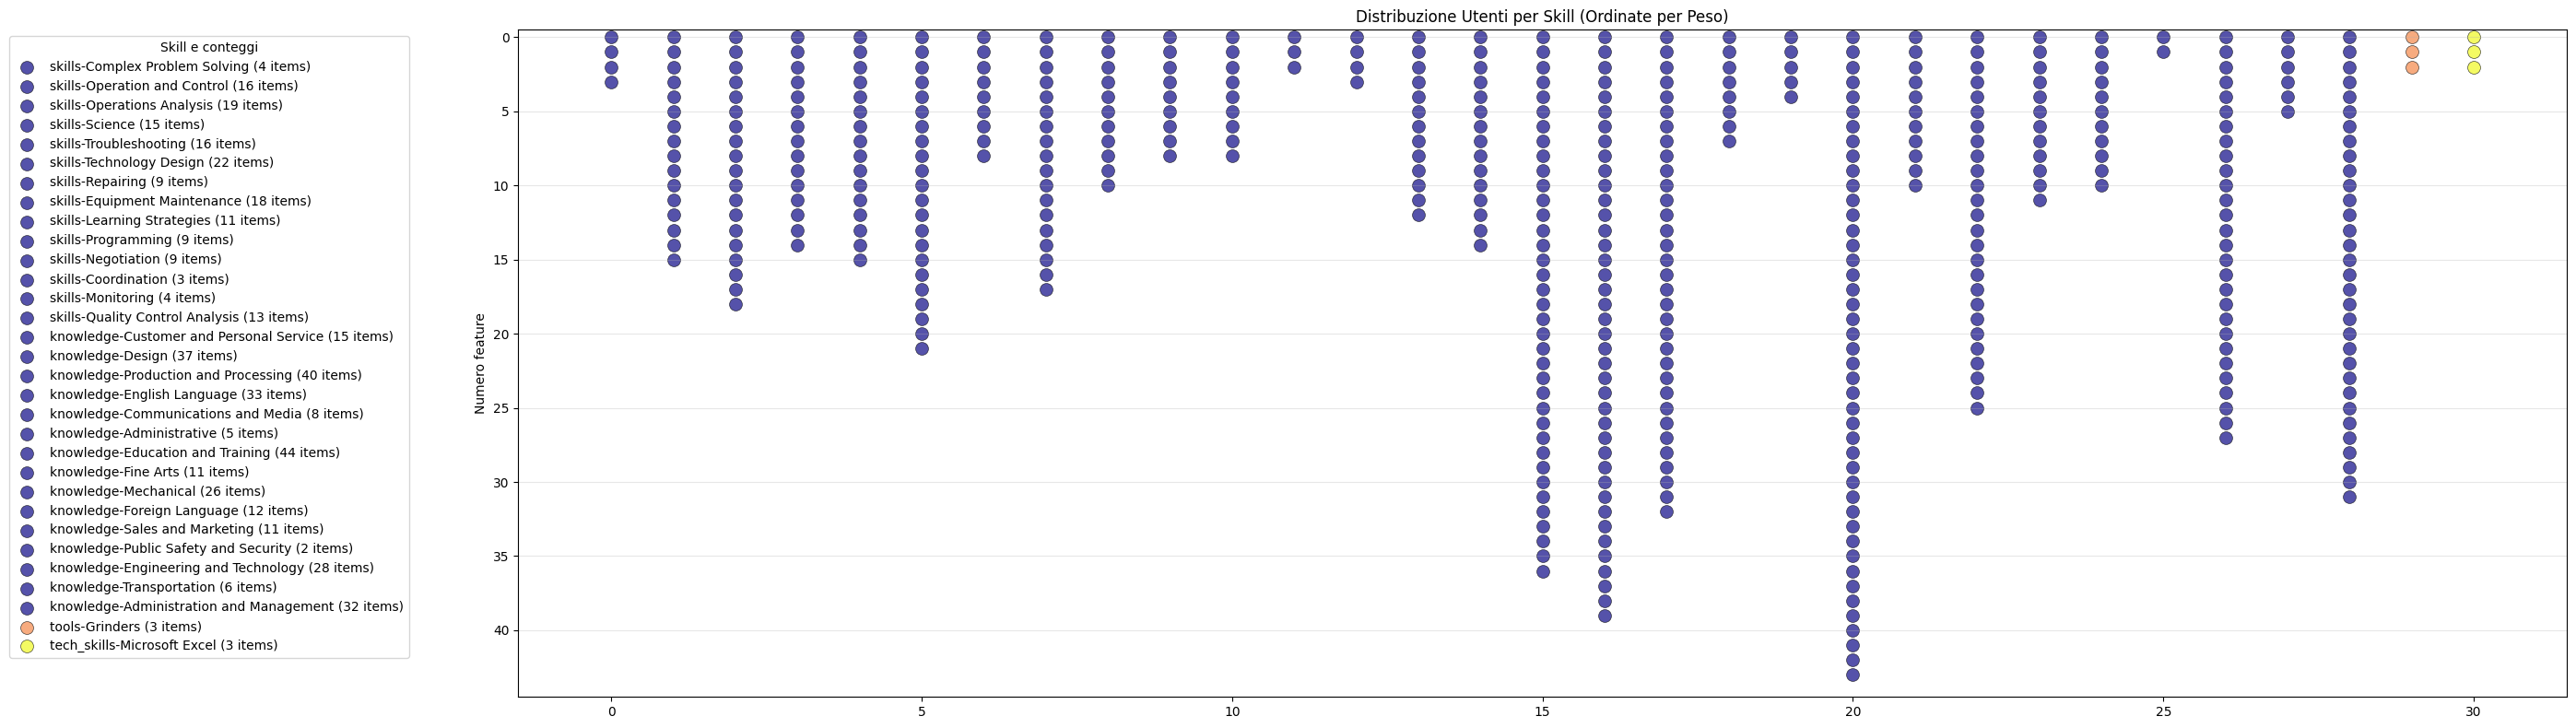

In [40]:
#Ordiniamo le skill per peso decrescente
sorted_skills = builtins.sorted(
    skill_only_columns, 
    key=lambda x: col_weights_dict.get(x, 0),
    reverse=True
)

#Calcoliamo il conteggio skill via Pandas
df_pd = convert_spark_to_pandas(df_filtered)  # Funzione personalizzata
skill_counts = df_pd[sorted_skills].sum()     # Pandas Series con i conteggi

#Normalizziamo i pesi per la colormap
weights = [col_weights_dict.get(skill, 0) for skill in sorted_skills]

#Se la lista è vuota, assegno valori di default
if not weights:
    min_w, max_w = 0, 1
else:
    min_w = builtins.min(weights)
    max_w = builtins.max(weights)

norm_weights = [
    (w - min_w) / (max_w - min_w) if (max_w != min_w) else 0.5
    for w in weights
]

# --------------------------------------------
# Creazione grafico
# --------------------------------------------
#Numero di skill
num_skills = len(sorted_skills)

#Base larghezza e incremento per skill
base_width = 8  #Larghezza base in pollici
width_per_skill = 0.5  #Incremento per ogni skill in pollici
dynamic_width = base_width + (num_skills - 1) * width_per_skill
plt.figure(figsize=(dynamic_width, 8))

for idx, (skill, count, nw) in enumerate(zip(sorted_skills, skill_counts, norm_weights)):
    
    #Adesso i valori di Y vanno da 0 a count-1
    #(il pallino con i=0 sarà il più in alto)
    y_positions = list(range(int(count)))  # <-- MODIFICA
    
    plt.scatter(
        x=[idx] * int(count),
        y=y_positions,
        s=100,
        color=plt.cm.plasma(1 - nw),
        alpha=0.7,
        edgecolors='black',
        linewidths=0.5,
        label=f'{skill} ({int(count)} items)'
    )

#Calcoliamo il limite superiore dell’asse Y in base al conteggio massimo
if skill_counts.empty:
    y_max = 1
else:
    y_max = skill_counts.max()

#Impostiamo i limiti dell’asse Y da 0 a y_max con margine
plt.ylim(-0.5, y_max + 0.5)

#Invertiamo l’asse Y così che 0 sia in alto
plt.gca().invert_yaxis()

#Label per l'asse Y
plt.ylabel("Numero feature")

plt.title('Distribuzione Utenti per Skill (Ordinate per Peso)')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.legend(
    title='Skill e conteggi',
    bbox_to_anchor=(-0.05, 1),  # Valore negativo per spostarla a sinistra
    loc='upper right'
)
plt.show()


### 5.4 barplot frequenze

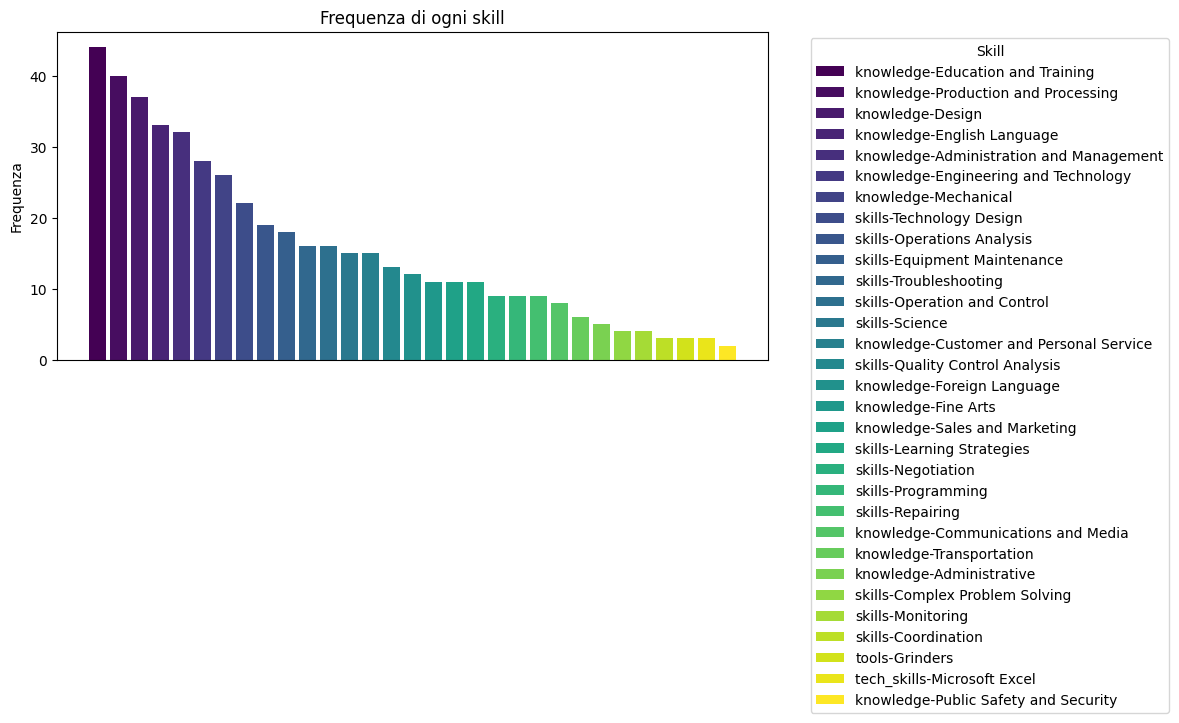

In [ ]:
#Calcoliamo la frequenza di ogni skill come somma dei valori 1 per colonna
skill_sums = pdf_sorted[skill_only_columns].sum()

#Ordiniamo le skill in base alla loro frequenza in modo decrescente
sorted_skill_sums = skill_sums.sort_values(ascending=False)

#Creiamo una palette di colori usando 'viridis' in base al numero di skill
bar_colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_skill_sums)))

plt.figure(figsize=(12, 6))
bars = plt.bar(sorted_skill_sums.index, sorted_skill_sums.values, color=bar_colors)

#Impostiamo l'etichetta di ogni barra
for bar, skill in zip(bars, sorted_skill_sums.index):
    bar.set_label(skill)

plt.xticks([])

# Aggiungiamo la legenda a destra
plt.legend(title='Skill', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("Frequenza di ogni skill")
plt.ylabel("Frequenza")
plt.tight_layout()
plt.show()
